# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Load depth to groundwater data
geo_well = pd.read_csv('data/LosAngelesGeoWell.txt', sep='\t', encoding='unicode_escape')

# Convert date to datetime
geo_well['GW_MEAS_DATE'] = pd.to_datetime(geo_well['GW_MEAS_DATE'],format='%Y-%m-%d', errors='coerce')

# Create a mask for any rows with dates past the current date and drop them.
mask = geo_well['GW_MEAS_DATE'] >= str(date.today())
geo_well = geo_well[~mask]

# Create a mask for any rows with dates before the specified date (01-01-2000) and drop them.
mask = geo_well['GW_MEAS_DATE'] <= '01-01-2000'
geo_well = geo_well[~mask]

# Drop any rows with null values for GW_MEAS_DATE and reset the index.
geo_well.dropna(subset=['GW_MEAS_DATE'], inplace=True)
geo_well.reset_index(drop=True, inplace=True)

# Fill NaNs with 0 for the DTFPROD and DTW columns.
geo_well['DTFPROD'].fillna(0, inplace=True)
geo_well['DTW'].fillna(0, inplace=True)

# Create a new column for the total depth to groundwater.
geo_well['DEPTH'] = np.nan

# Create mask for rows with DTFPROD == 0 then sets DEPTH equal to DTW.
mask = geo_well['DTFPROD'] == 0
geo_well.loc[mask, 'DEPTH'] = geo_well['DTW']

# Create maks for rows with DTW == 0 then sets DEPTH equal to DTFPROD.
mask = geo_well['DTW'] == 0
geo_well.loc[mask, 'DEPTH'] = geo_well['DTFPROD']

# Create a mask for rows with DTFPROD != 0 and DTW != 0 then sets DEPTH equal to DTW.
mask = (geo_well['DTW'] != 0) & (geo_well['DTFPROD'] != 0)
geo_well.loc[mask, 'DEPTH'] = geo_well['DTW']

# Create mask for rows with depth of 0 and drop them.
mask = geo_well['DEPTH'] == 0
geo_well = geo_well[~mask]

# Create a WID column.
geo_well['WID'] = geo_well['GLOBAL_ID'] + '-' + geo_well['FIELD_POINT_NAME']
geo_well['GID'] = geo_well['WID'] +' | ' + geo_well['GW_MEAS_DATE'].astype(str)

c:\Users\chief\.conda\envs\geoprj\lib\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (3,4,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Load the top of well elevation data.
geo_z = pd.read_csv('data/LosAngelesGeoZ.txt', sep='\t', encoding='unicode_escape', on_bad_lines='warn')

# Fill in NaN values with 0
geo_z['RISER_HT'].fillna(0, inplace=True)

# Remove invalid rows
geo_z.drop(geo_z[geo_z['RISER_HT'] == '2009-12-18'].index, inplace=True)

# Add RISER_HT to the ELEVATION column to get true well casing elevation (where depth to water is measured from).
geo_z['ELEVATION'] = geo_z['ELEVATION'] + geo_z['RISER_HT'].astype(float)

# Remove rows with invalid ELEVATION values
geo_z.dropna(subset=['ELEVATION'], inplace=True)

# Create WID column.
geo_z['WID'] = geo_z['GLOBAL_ID'] + '-' + geo_z['FIELD_PT_NAME']

# Keep only requied columns.
geo_z = geo_z[['WID', 'ELEVATION']]

b'Skipping line 211619: expected 12 fields, saw 20\n'
c:\Users\chief\.conda\envs\geoprj\lib\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (2,5,9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [42]:
geo = pd.merge(geo_well, geo_z, on='WID', how='left')
geo.dropna(subset=['ELEVATION'], inplace=True)
geo.drop_duplicates(subset=['GID'], inplace=True)
geo['WATER_ELEVATION'] = geo['ELEVATION'] - geo['DEPTH']
geo.dropna(subset=['WATER_ELEVATION'], inplace=True)
geo.sort_values(by=['GW_MEAS_DATE'], inplace=True)
geo.reset_index(drop=True, inplace=True)

In [43]:
geo

,COUNTY,GLOBAL_ID,FIELD_POINT_NAME,STATUS,GW_MEAS_DATE,DTFPROD,DTW,RISER_HT,TOT_DEPTH,GW_MEAS_DESC,SHEEN,DEPTH,WID,GID,ELEVATION,WATER_ELEVATION
0,Los Angeles,SL603792561,MW-10,ACT,2000-01-27,0.0,90.30,NaN,NaN,NaN,N,90.30,SL603792561-MW-10,SL603792561-MW-10 | 2000-01-27,78.50,-11.80
1,Los Angeles,SLT4307472,115A,ACT,2000-01-27,0.0,142.46,NaN,158.5,NaN,N,142.46,SLT4307472-115A,SLT4307472-115A | 2000-01-27,151.94,9.48
2,Los Angeles,SL603792561,MW-14,ACT,2000-01-27,0.0,60.85,NaN,NaN,NaN,N,60.85,SL603792561-MW-14,SL603792561-MW-14 | 2000-01-27,76.25,15.40
3,Los Angeles,SL603792561,MW-04,ACT,2000-01-27,0.0,60.33,NaN,NaN,NaN,N,60.33,SL603792561-MW-04,SL603792561-MW-04 | 2000-01-27,77.28,16.95
4,Los Angeles,SL603792561,MW-12,ACT,2000-01-27,0.0,60.91,NaN,NaN,NaN,N,60.91,SL603792561-MW-12,SL603792561-MW-12 | 2000-01-27,76.19,15.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645294,Los Angeles,SL204CP1893,MW6,ACT,2022-06-30,0.0,54.93,63.22,80.0,NaN,N,54.93,SL204CP1893-MW6,SL204CP1893-MW6 | 2022-06-30,62.65,7.72
645295,Los Angeles,SL204CP1893,MW7A,ACT,2022-06-30,0.0,50.54,61.83,59.0,NaN,N,50.54,SL204CP1893-MW7A,SL204CP1893-MW7A | 2022-06-30,61.48,10.94
645296,Los Angeles,SL204CP1893,MW7B,ACT,2022-06-30,0.0,54.12,61.58,100.0,NaN,N,54.12,SL204CP1893-MW7B,SL204CP1893-MW7B | 2022-06-30,60.96,6.84
645297,Los Angeles,SL204CP1893,MW1,ACT,2022-06-30,0.0,52.46,63.55,60.0,NaN,N,52.46,SL204CP1893-MW1,SL204CP1893-MW1 | 2022-06-30,63.14,10.68


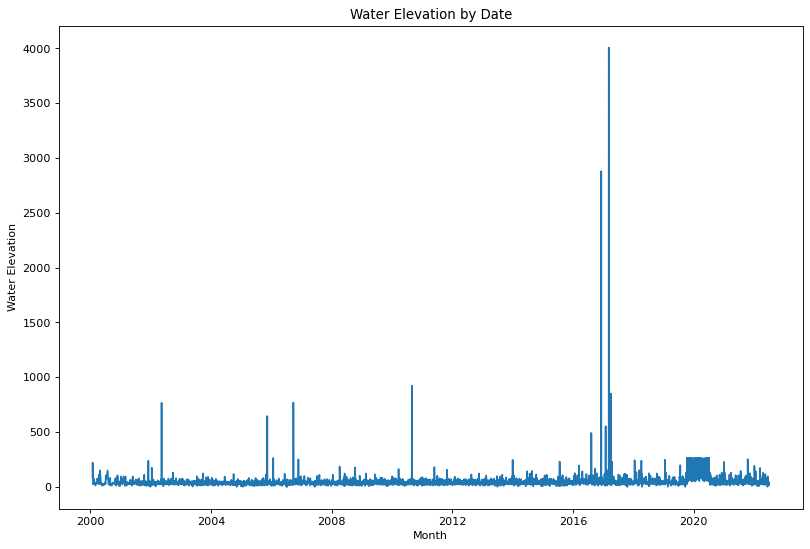

In [44]:
x_labels = []
x_ticks = []
for i in range(12):
    x_ticks.append(i*30.5)
    x_labels.append(str(i+1))

by_date = geo.groupby(['GW_MEAS_DATE']).mean().reset_index()
plt.figure(figsize=(12,8), dpi=80)
plt.plot(by_date['GW_MEAS_DATE'], by_date['DEPTH'])
plt.xlabel('Month')
plt.ylabel('Water Elevation')
plt.title('Water Elevation by Date')
plt.show()

In [51]:
from collections import Counter

counter = Counter(geo['WID'])

In [52]:
counter

Counter({'SL603792561-MW-10': 45,
         'SLT4307472-115A': 40,
         'SL603792561-MW-14': 51,
         'SL603792561-MW-04': 45,
         'SL603792561-MW-12': 51,
         'SL603792561-MW-11': 45,
         'SLT4307472-4A': 40,
         'SLT4307472-57A': 41,
         'SL603792561-MW-01': 51,
         'SL603792561-MW-08': 50,
         'SL603792561-MW-05': 51,
         'SL603792561-MW-06': 45,
         'SL603792561-MW-09': 51,
         'SL603792561-MW-07': 45,
         'SL603798629-SW-1': 22,
         'SL603798629-SW-2': 22,
         'SL603798629-SW-4': 7,
         'SL603798629-SW-5': 22,
         'SL603798629-SW-3': 23,
         'SL204791669-DPEW-1': 41,
         'T0603703926-JMW-2': 46,
         'T0603703926-JMW-5': 45,
         'T0603703926-RMW-6': 45,
         'T0603703926-JMW-1': 43,
         'T0603703926-MW-10': 46,
         'T0603703926-MW-12': 46,
         'T0603703926-JMW-6': 46,
         'T0603703926-MW-11': 44,
         'T0603703926-RMW-4': 45,
         'T0603703926-RMW-7'

In [55]:
wids = []
for i in counter.items():
    if i[1] >= 100:
        wids.append(i[0])

In [47]:
import sklearn.linear_model as lm
import sklearn.model_selection as ms
import sklearn.metrics as metrics

In [56]:
wids

['T0603703277-MW-17S2',
 'T0603703277-MW-11M',
 'T0603703277-MW-8M',
 'T0603703277-MW-10S',
 'T0603703277-MW-15S',
 'T0603703277-MW-18S',
 'T0603703277-MW-11S',
 'T0603703277-MW-12S',
 'T0603703277-MW-18M',
 'T0603703277-MW-14S',
 'T0603703277-MW-7M',
 'T0603703277-MW-12M',
 'T0603703277-MW-17M',
 'T0603703277-MW-14M',
 'T0603703277-MW-13S',
 'T0603703277-MW-13M',
 'T0603703277-MW-16S',
 'T0603703277-MW-7S',
 'T0603703277-MW-8S',
 'T0603703277-MW-16M',
 'T0603703277-MW-15M',
 'T0603703277-MW-17S',
 'T0603704295-PZ-1',
 'T0603703277-MW-21M',
 'T0603703277-VE-4',
 'T0603703277-MW-7D',
 'T0603703277-MW-9M',
 'T0603703277-MW-9S',
 'T0603703277-VE-6C',
 'T0603703277-VE-5C',
 'T0603703277-MW-20S',
 'T0603703277-MW-19M',
 'T0603703277-VE-8C',
 'T0603703277-VE-9A',
 'T0603703277-MW-16D',
 'T0603703277-MW-22S',
 'T0603703049-B-20',
 'T0603703277-MW-19S',
 'T0603702480-MW-5',
 'T0603702480-MW-4',
 'T0603702480-PW-1',
 'T0603702480-MW-3',
 'T0603702480-PW-2',
 'T0603702480-MW-2',
 'T0603702480-MW

In [81]:
j = wids[5]
df = geo[geo['WID'] == j].copy()
df['GW_MEAS_DATE'] = pd.to_numeric(df['GW_MEAS_DATE'])
df.sort_values(by='GW_MEAS_DATE', inplace=True)
df['ZSCORE'] = df['DEPTH'].apply(lambda x: (x - df['DEPTH'].mean()) / df['DEPTH'].std())
mask = abs(df['ZSCORE'] ) > 3
df = df[~mask]
df.reset_index(drop=True, inplace=True)

In [82]:
df

,COUNTY,GLOBAL_ID,FIELD_POINT_NAME,STATUS,GW_MEAS_DATE,DTFPROD,DTW,RISER_HT,TOT_DEPTH,GW_MEAS_DESC,SHEEN,DEPTH,WID,GID,ELEVATION,WATER_ELEVATION,ZSCORE
0,Los Angeles,T0603703277,MW-18S,ACT,1002067200000000000,0.0,58.56,NaN,NaN,NaN,U,58.56,T0603703277-MW-18S,T0603703277-MW-18S | 2001-10-03,61.97,3.41,2.137577
1,Los Angeles,T0603703277,MW-18S,ACT,1002672000000000000,0.0,58.45,NaN,NaN,NaN,U,58.45,T0603703277-MW-18S,T0603703277-MW-18S | 2001-10-10,61.97,3.52,2.083622
2,Los Angeles,T0603703277,MW-18S,ACT,1003276800000000000,0.0,58.41,NaN,NaN,NaN,U,58.41,T0603703277-MW-18S,T0603703277-MW-18S | 2001-10-17,61.97,3.56,2.064002
3,Los Angeles,T0603703277,MW-18S,ACT,1003795200000000000,0.0,58.21,NaN,NaN,NaN,U,58.21,T0603703277-MW-18S,T0603703277-MW-18S | 2001-10-23,61.97,3.76,1.965903
4,Los Angeles,T0603703277,MW-18S,ACT,1004486400000000000,0.0,55.29,NaN,NaN,NaN,U,55.29,T0603703277-MW-18S,T0603703277-MW-18S | 2001-10-31,61.97,6.68,0.533648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,Los Angeles,T0603703277,MW-18S,ACT,1082505600000000000,0.0,49.51,NaN,NaN,NaN,U,49.51,T0603703277-MW-18S,T0603703277-MW-18S | 2004-04-21,61.97,12.46,-2.301432
134,Los Angeles,T0603703277,MW-18S,ACT,1083110400000000000,0.0,52.44,NaN,NaN,NaN,U,52.44,T0603703277-MW-18S,T0603703277-MW-18S | 2004-04-28,61.97,9.53,-0.864272
135,Los Angeles,T0603703277,MW-18S,ACT,1083715200000000000,0.0,53.42,NaN,NaN,NaN,U,53.42,T0603703277-MW-18S,T0603703277-MW-18S | 2004-05-05,61.97,8.55,-0.383584
136,Los Angeles,T0603703277,MW-18S,ACT,1084406400000000000,0.0,52.49,NaN,NaN,NaN,U,52.49,T0603703277-MW-18S,T0603703277-MW-18S | 2004-05-13,61.97,9.48,-0.839747


In [110]:
model = lm.LinearRegression()
blank = pd.DataFrame(columns=['WID','R2','ADJ_R2','MAE','MSE','RMSE'])

res = blank.copy()
res_count = 0
total = len(wids)


for j in wids:
        tdf = blank.copy()
        tdf_count = 0
        df = geo[geo['WID'] == j].copy()
        df['GW_MEAS_DATE'] = pd.to_numeric(df['GW_MEAS_DATE'])
        df.sort_values(by='GW_MEAS_DATE', inplace=True)
        df['ZSCORE'] = df['DEPTH'].apply(lambda x: (x - df['DEPTH'].mean()) / df['DEPTH'].std())
        mask = abs(df['ZSCORE'] ) > 3
        df = df[~mask]
        df.reset_index(drop=True, inplace=True)
        for n in range(200):

                x_train, x_test, y_train, y_test = ms.train_test_split(
                        df['GW_MEAS_DATE'], df['DEPTH'], test_size=0.2
                        )

                x_train = x_train.to_numpy().reshape(-1, 1)
                x_test = x_test.to_numpy().reshape(-1, 1)
                y_train = y_train.to_numpy()
                y_test = y_test.to_numpy()

                model.fit(x_train, y_train)

                y_pred = model.predict(x_test)

                r2 = metrics.r2_score(y_test, y_pred)
                adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - x_train.shape[1] - 1)
                mae = metrics.mean_absolute_error(y_test, y_pred)
                mse = metrics.mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)

                tdf.loc[tdf_count] = [j, r2, adj_r2, mae, mse, rmse]
                tdf_count += 1

        tdf = tdf.mean(numeric_only=True).to_frame().T.reset_index().rename(columns={'index':'WID'})
        tdf['WID'] = j
        res.loc[res_count] = tdf.loc[0]
        res_count += 1
        pct = res_count / total * 100
        if int(pct) % 5 == 0:
                print(f'{pct:.2f}%')

0.50%
5.03%
5.53%
10.05%
10.55%
15.08%
15.58%
20.10%
20.60%
25.13%
25.63%
30.15%
30.65%
35.18%
35.68%
40.20%
40.70%
45.23%
45.73%
50.25%
50.75%
55.28%
55.78%
60.30%
60.80%
65.33%
65.83%
70.35%
70.85%
75.38%
75.88%
80.40%
80.90%
85.43%
85.93%
90.45%
90.95%
95.48%
95.98%
100.00%


In [107]:
res.describe()

,R2,ADJ_R2,MAE,MSE,RMSE
count,199.000000,199.000000,199.000000,199.000000,199.000000
mean,0.183797,0.151955,5.378991,113.804640,6.892590
std,2.239077,2.356452,6.475748,239.660563,7.991239
min,-30.707007,-32.375797,0.000000,0.000000,0.000000
25%,0.013595,-0.018238,1.382802,3.042804,1.719726
50%,0.231038,0.212074,1.726695,4.755111,2.171357
75%,0.719872,0.704310,9.089809,115.485928,10.704436
max,1.000000,1.000000,41.386275,1974.148805,44.377791


In [109]:
res.describe()

,R2,ADJ_R2,MAE,MSE,RMSE
count,199.000000,199.000000,199.000000,199.000000,199.000000
mean,0.322032,0.297509,5.370661,113.380082,6.877175
std,0.450239,0.467856,6.476770,241.576862,7.983397
min,-1.798809,-1.938749,0.000000,0.000000,0.000000
25%,0.016607,-0.010191,1.380672,2.998449,1.712642
50%,0.239582,0.214523,1.740699,4.958361,2.209335
75%,0.722400,0.710851,9.012180,115.986708,10.728784
max,1.000000,1.000000,41.429553,1993.613909,44.574094


In [111]:
res.describe()

,R2,ADJ_R2,MAE,MSE,RMSE
count,199.000000,199.000000,199.000000,199.000000,199.000000
mean,0.225427,0.195693,5.366374,113.340087,6.873877
std,1.333990,1.403377,6.481063,242.095442,7.983338
min,-16.961927,-17.907292,0.000000,0.000000,0.000000
25%,0.008042,-0.020084,1.393185,3.040252,1.730321
50%,0.220077,0.184201,1.744588,4.879227,2.192824
75%,0.711121,0.697232,9.014289,115.561560,10.717125
max,1.000000,1.000000,41.783230,2019.200375,44.877012


In [113]:
res[abs(res['R2']) <= 1].describe()

,R2,ADJ_R2,MAE,MSE,RMSE
count,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.352998,0.330354,5.218821,108.320207,6.635719
std,0.373109,0.384403,6.460099,241.735303,7.882750
min,-0.307112,-0.355524,0.000000,0.000000,0.000000
25%,0.017667,-0.005978,1.384447,2.992385,1.716802
50%,0.221875,0.191481,1.702230,4.673439,2.144935
75%,0.713835,0.702248,8.817678,112.493690,10.560528
max,1.000000,1.000000,41.783230,2019.200375,44.877012
